# **A2C Algorithm (Stable Baseline3)**

Use Stable Baselines3 to train an Advantage Actor-Critic (A2C) agent on the CartPole-v1 environment.

1. **Visualize A2C Algorithm**:
Visualization of the A2C algorithm's architecture using Graphviz.

2. **Install Dependencies**:
Install required packages for reinforcement learning, environment simulation, and visualization.

3. **Import Libraries**:
Import essential libraries for model training, hyperparameter tuning, and video processing.

4. **Define Helper Functions and Custom Callbacks**:
Define functions and callbacks for rendering frames, creating animations, and logging rewards and videos.

5. **Define Optuna Optimization Function**:
Create a function to optimize hyperparameters using Optuna.

6. **Run Optuna Study**:
Perform hyperparameter optimization with Optuna and print the best hyperparameters.

7. **Train the Final Model with Best Hyperparameters**:
Train the A2C model using the best hyperparameters found and save the training video.

8. **Plot Rewards of Training**:
Plot and visualize the rewards obtained during training.

9. **Animation of Training**:
Display training animation.

10. **Evaluate the Model, Plot Rewrads, Capture Evaluation Frames & Animate**:
Evaluate the trained model, capture frames, and save the evaluation video. Also Plot rewards of the evaluation

# Visualize A2C Algorithm

A2C Algorithm block diagram created successfully!


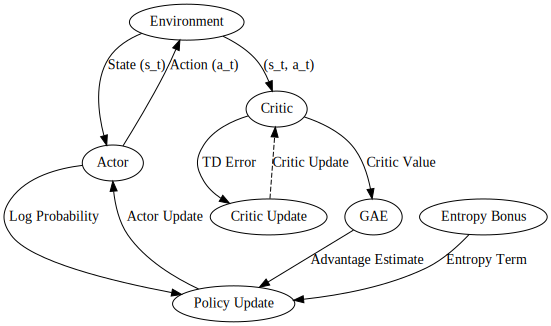

In [2]:
# This code creates a diagram of the Advantage Actor-Critic (A2C) algorithm using `graphviz`.
# It visualizes how the Environment, Actor, Critic, and their updates interact.
# The final diagram is saved as 'a2c_diagram.png' and displayed.

import graphviz
from graphviz import Digraph

# Define the graph
dot = Digraph(name='A2C_Algorithm', format='png')

# Add nodes
dot.node('environment', label='Environment')
dot.node('actor', label='Actor')
dot.node('critic', label='Critic')
dot.node('policy_update', label='Policy Update')
dot.node('critic_update', label='Critic Update')
dot.node('gae', label='GAE')
dot.node('entropy', label='Entropy Bonus')

# Add edges with labels
dot.edge('environment', 'actor', label='State (s_t)')
dot.edge('actor', 'environment', label='Action (a_t)')
dot.edge('environment', 'critic', label='(s_t, a_t)')
dot.edge('critic', 'gae', label='Critic Value')
dot.edge('gae', 'policy_update', label='Advantage Estimate')
dot.edge('actor', 'policy_update', label='Log Probability')
dot.edge('entropy', 'policy_update', label='Entropy Term')
dot.edge('policy_update', 'actor', label='Actor Update')
dot.edge('critic', 'critic_update', label='TD Error')
dot.edge('critic_update', 'critic', label='Critic Update', style='dashed')

# Render the graph
dot.render('a2c_diagram.png', view=True)

print("A2C Algorithm block diagram created successfully!")

# Show the graph
dot


The **A2C (Advantage Actor-Critic) algorithm** diagram visually represents the key components and data flow involved in the A2C reinforcement learning algorithm, including the roles of GAE and the entropy term. Here’s a summary of the diagram's components and their interactions:

**Environment**: The environment interacts with the agent by providing states and rewards. It receives actions from the Actor and sends state-action pairs to the Critic.

**Actor**: The Actor network decides which action to take based on the current state. It receives the state from the environment, chooses an action, and sends it back. The Actor also receives updates from the Policy Update step to improve its policy.

**Critic**: The Critic network estimates the value of states or state-action pairs. It receives state-action pairs from the environment and provides value estimates to the Policy Update step. The Critic is updated based on the TD (temporal difference) error, which reflects the difference between predicted and actual rewards.

**Generalized Advantage Estimation (GAE)**: GAE calculates the advantage function, which measures how good the taken actions are relative to the estimated values. This helps in reducing variance during policy updates.

**Entropy Bonus**: The entropy term encourages exploration by adding randomness to the policy updates, helping prevent premature convergence to suboptimal policies.

**Policy Update**: This step updates the Actor based on the computed advantage function from GAE and the log probability of the chosen action, along with the entropy bonus.

**Critic Update**: This step refines the Critic’s value function based on the TD error, which is the difference between the predicted value and the actual reward plus the discounted value of the next state.

**Data Flow**:

The Environment sends the state to the Actor and receives actions from it.

The Actor provides actions to the Environment and logs the probabilities of those actions.

The Environment provides state-action pairs to the Critic for value estimation.
The Critic calculates the TD error and provides value estimates to the GAE and Policy Update steps.

GAE uses the Critic's output to compute the advantage function and sends it to the Policy Update step.

The Policy Update step uses the advantage function, the Actor’s log probabilities, and the entropy bonus to update the Actor.

The Critic is updated based on the TD error received from the Critic Update step.

The diagram encapsulates the iterative process of updating both the Actor and Critic networks to optimize the policy and value function, enhancing decision-making in reinforcement learning. The inclusion of GAE and the entropy term illustrates how A2C balances exploration and exploitation, improving training stability and performance.

# Install Dependencies

In [ ]:
# Install the required Python packages for Stable Baselines3, Gym, Matplotlib, shimmy, opencv-python and Optuna.

!pip install --upgrade stable-baselines3 gymnasium matplotlib==3.6.0 optuna shimmy opencv-python


  Using cached Shimmy-2.0.0-py3-none-any.whl.metadata (3.5 kB)
INFO: pip is looking at multiple versions of shimmy to determine which version is compatible with other requirements. This could take a while.


# Import Libraries

In [ ]:
# Import necessary libraries for reinforcement learning, hyperparameter tuning, and visualization.

import numpy as np
import gymnasium as gym  # Use Gymnasium instead of OpenAI Gym
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from matplotlib import animation
from IPython.display import display, HTML
import cv2
from base64 import b64encode
import pandas as pd
import optuna
from google.colab import files
import os
import torch

# Helper Functions and Custom Callbacks

In [ ]:
# Define helper functions and custom callbacks for video rendering and reward logging.

def display_video(video_path):
    """Display a video in a Jupyter Notebook from a given file path."""
    with open(video_path, 'rb') as f:
        video_data = f.read()
    video_base64 = b64encode(video_data).decode()
    video_html = f"""
    <video width="600" controls>
        <source src="data:video/mp4;base64,{video_base64}" type="video/mp4">
    </video>
    """
    display(HTML(video_html))

class VideoCallback(BaseCallback):
    def __init__(self, save_path, env, freq, verbose=0):
        super(VideoCallback, self).__init__(verbose)
        self.save_path = save_path
        self.env = env
        self.freq = freq
        self.frames = []

    def _init_callback(self):
        if self.verbose > 0:
            print(f"VideoCallback initialized. Saving video to {self.save_path}")

    def _on_step(self) -> bool:
        if self.n_calls % self.freq == 0:
            img = self.env.render(mode='rgb_array')
            if img is not None:
                img = cv2.resize(img, (300, 200))
                self.frames.append(img)
        return True

    def _on_training_end(self):
        if self.frames:
            out = cv2.VideoWriter(self.save_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (300, 200))
            for frame in self.frames:
                out.write(frame)
            out.release()
            print(f"Video saved to {self.save_path}")

# Define a callback to log rewards
class RewardLoggerCallback(BaseCallback):
    """Custom callback to log rewards during training and print them."""
    def __init__(self, log_path, print_interval=10, verbose=1):
        super().__init__(verbose)
        self.log_path = log_path
        self.print_interval = print_interval
        self.episode_rewards = []
        self.current_reward = 0  # Accumulate rewards for the current episode

    def _init_callback(self):
        if self.verbose > 0:
            print(f"RewardLoggerCallback initialized. Logging rewards to {self.log_path}")

    def _on_step(self) -> bool:
        # Access rewards directly from locals
        rewards = self.locals.get('rewards', [])
        
        # Accumulate rewards for the current episode
        if rewards:
            self.current_reward += sum(rewards)

        # Check if an episode has ended
        if self.locals.get('dones', [])[0]:  # Assuming the first element indicates if the episode is done
            self.episode_rewards.append(self.current_reward)
            print(f"Episode {len(self.episode_rewards)}: Total reward: {self.current_reward}")

            # Reset current reward for the next episode
            self.current_reward = 0

        return True

    def _on_training_end(self):
        # Save rewards to a CSV file at the end of training
        df = pd.DataFrame({'Episode': range(1, len(self.episode_rewards) + 1),
                           'Total Reward': self.episode_rewards})
        df.to_csv(self.log_path, index=False)
        print(f"Training finished. Rewards logged to {self.log_path}")

# Define Optuna Optimization Function

In [ ]:
# Define an Optuna objective function for hyperparameter tuning, which trains the A2C model and evaluates its performance.
#
# This `objective` function is designed for hyperparameter optimization using Optuna for the A2C (Advantage Actor-Critic) algorithm.
#
# - **Hyperparameters to Optimize**:
#   - `n_steps`: Number of steps to run for each environment per update.
#   - `gamma`: Discount factor for future rewards.
#   - `gae_lambda`: GAE (Generalized Advantage Estimation) lambda parameter.
#   - `ent_coef`: Coefficient for the entropy term, which encourages exploration.
#   - `vf_coef`: Coefficient for the value function loss.
#   - `learning_rate`: Learning rate for the optimizer.
#
# - **Training and Evaluation**:
#   - The function creates a CartPole environment, wraps it with `DummyVecEnv`, and trains an A2C model with the specified hyperparameters.
#   - After training, it evaluates the model over 10 episodes, calculates the total reward, and returns the average reward as the objective value.
#
# The goal is to find the hyperparameters that maximize the mean reward across these episodes.



def objective(trial):
    """Optuna objective function to optimize hyperparameters for A2C."""
    n_steps = trial.suggest_categorical("n_steps", [5, 10, 20, 50])
    gamma = trial.suggest_float("gamma", 0.9, 0.999, log=True)
    gae_lambda = trial.suggest_float("gae_lambda", 0.8, 0.95, log=True)
    ent_coef = trial.suggest_float("ent_coef", 1e-5, 0.01, log=True)
    vf_coef = trial.suggest_float("vf_coef", 0.1, 1.0, log=True)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    num_envs = 8  # Number of environments

    # Determine if GPU is available
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Create a vectorized environment using DummyVecEnv with render_mode='rgb_array'
    env = DummyVecEnv([lambda: gym.make("CartPole-v1", render_mode="rgb_array") for _ in range(num_envs)])

    # Initialize the A2C model and specify the device
    model = A2C("MlpPolicy", env, n_steps=n_steps, gamma=gamma, gae_lambda=gae_lambda,
                ent_coef=ent_coef, vf_coef=vf_coef, learning_rate=learning_rate,
                verbose=0, tensorboard_log="./a2c_cartpole_tensorboard/", device=device)

    # Train the model
    model.learn(total_timesteps=1000000)

    # Evaluate the model
    total_reward = 0
    for _ in range(10):  # Evaluate over 10 episodes
        obs = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, rewards, dones, infos = env.step(action)
            total_reward += sum(rewards)  # Sum the rewards across environments
            if any(dones):
                break  # Break if any environment is done

    mean_reward = total_reward / 10

    return mean_reward


# Run Optuna Study

In [ ]:
# Create and run an Optuna study to optimize the hyperparameters by running multiple trials.

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_params)

[I 2024-09-14 06:27:45,640] A new study created in memory with name: no-name-11593125-f623-4928-87d0-0e13d495fc84
[I 2024-09-14 06:31:50,391] Trial 0 finished with value: 4000.0 and parameters: {'n_steps': 20, 'gamma': 0.963888795984254, 'gae_lambda': 0.8207431467396504, 'ent_coef': 0.003025956956565523, 'vf_coef': 0.32555106650994053, 'learning_rate': 0.0029535916948484186}. Best is trial 0 with value: 4000.0.
[I 2024-09-14 06:35:37,633] Trial 1 finished with value: 1286.4 and parameters: {'n_steps': 50, 'gamma': 0.9748802869688169, 'gae_lambda': 0.9194390631968822, 'ent_coef': 0.003997676823676886, 'vf_coef': 0.30784978690541276, 'learning_rate': 0.00010014568455784968}. Best is trial 0 with value: 4000.0.
[I 2024-09-14 06:39:56,166] Trial 2 finished with value: 3904.0 and parameters: {'n_steps': 20, 'gamma': 0.9555930849006412, 'gae_lambda': 0.9072828423321918, 'ent_coef': 0.001299687759804953, 'vf_coef': 0.38155092555377473, 'learning_rate': 0.00016907659488044283}. Best is trial 0

Best hyperparameters: {'n_steps': 20, 'gamma': 0.963888795984254, 'gae_lambda': 0.8207431467396504, 'ent_coef': 0.003025956956565523, 'vf_coef': 0.32555106650994053, 'learning_rate': 0.0029535916948484186}


# Train the Final Model with Best Hyperparameters

In [ ]:
# Train the final A2C model using the best hyperparameters found by Optuna, and set up callbacks for video and reward logging.

best_params = study.best_params

num_envs = 1  # Number of environments
# Determine if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create a vectorized environment using DummyVecEnv with render_mode='rgb_array'
env = DummyVecEnv([lambda: gym.make("CartPole-v1", render_mode="rgb_array") for _ in range(num_envs)])

model = A2C("MlpPolicy", env, n_steps=best_params['n_steps'], gamma=best_params['gamma'],
            gae_lambda=best_params['gae_lambda'], ent_coef=best_params['ent_coef'],
            vf_coef=best_params['vf_coef'], verbose=1, tensorboard_log="./a2c_cartpole_tensorboard/",device=device)

video_path = "training_video.mp4"
reward_log_path = "reward_log.csv"

video_callback = VideoCallback(save_path=video_path, env=env, freq=1000)
reward_logger_callback = RewardLoggerCallback(log_path=reward_log_path, print_interval=10)

model.learn(total_timesteps=500000, callback=[video_callback, reward_logger_callback])

# Define a function to save and load the model
def save_model(model, path):
    """Save the trained model."""
    model.save(path)

# Save the trained model
save_model(model, "trained_a2c_model")

Using cuda device
Logging to ./a2c_cartpole_tensorboard/A2C_43
Episode 1: Average reward: 13.0
Episode 2: Average reward: 16.0
Episode 3: Average reward: 11.0
Episode 4: Average reward: 12.0
Episode 5: Average reward: 15.0
Episode 6: Average reward: 19.0
Episode 7: Average reward: 13.0
Episode 8: Average reward: 13.0
Episode 9: Average reward: 30.0
Episode 10: Average reward: 21.0
Total rewards after 10 episodes: 0
Episode 11: Average reward: 13.0
Episode 12: Average reward: 23.0
Episode 13: Average reward: 29.0
Episode 14: Average reward: 22.0
Episode 15: Average reward: 15.0
Episode 16: Average reward: 18.0
Episode 17: Average reward: 19.0
Episode 18: Average reward: 9.0
Episode 19: Average reward: 10.0
Episode 20: Average reward: 21.0
Total rewards after 20 episodes: 0
Episode 21: Average reward: 14.0
Episode 22: Average reward: 19.0
Episode 23: Average reward: 17.0
Episode 24: Average reward: 18.0
Episode 25: Average reward: 20.0
Episode 26: Average reward: 20.0
Episode 27: Average

# Plot Rewards of Training

Index(['Episode', 'Average Reward'], dtype='object')
   Episode  Average Reward
0        1            13.0
1        2            16.0
2        3            11.0
3        4            12.0
4        5            15.0


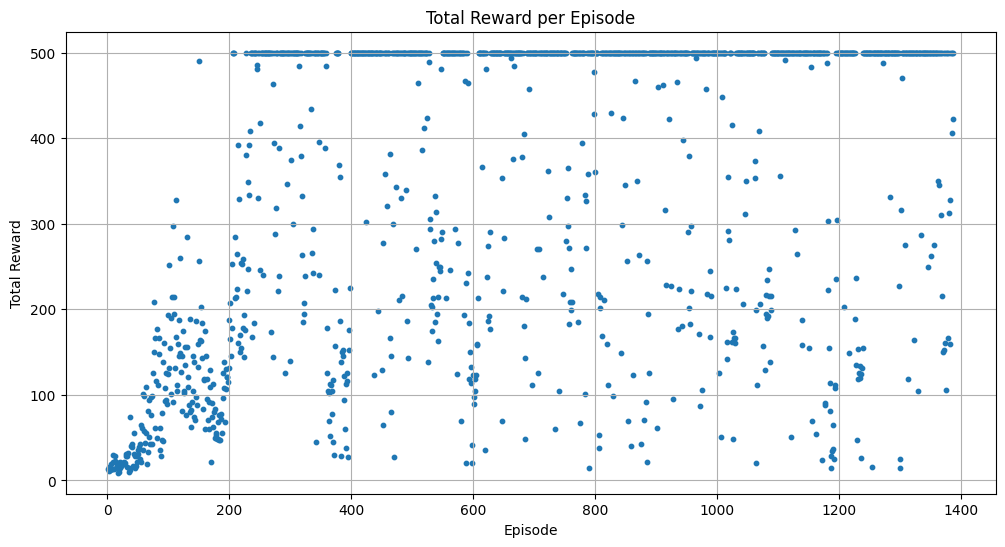

In [ ]:
# Load the reward log data and plot the rewards obtained during the training process.

# Load the reward log data
reward_data = pd.read_csv(reward_log_path)

# Check the structure of the DataFrame
print(reward_data.columns)  # Print the column names
print(reward_data.head())    # Print the first few rows of the DataFrame

# Calculate the total reward per episode
if 'Total Reward' in reward_data.columns:
    episode_rewards = reward_data[['Episode', 'Total Reward']]  # Use 'Total Reward'
else:
    print("Column 'Total Reward' not found. Please check the column names.")

# Plot the total rewards per episode if the calculation was successful
if 'episode_rewards' in locals():  # This check is not needed, use `if episode_rewards is not None`
    plt.figure(figsize=(12, 6))
    plt.scatter(episode_rewards['Episode'], episode_rewards['Total Reward'], s=10)  # Use 'Total Reward'
    plt.title("Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.show()
else:
    print("Failed to calculate episode rewards.")


# Animation of Training

In [ ]:
"""
Process a video file and creates an animation from its frames.
The animation is displayed as an HTML5 video with playback controls in a Jupyter Notebook.

The process is divided into the following steps:
1. **Extract Frames**: The `extract_frames_from_video` function reads a video file and extracts its frames, converting them to RGB format.
2. **Plot Animation**: The `plot_animation` function creates an animation object from the extracted frames using matplotlib's `FuncAnimation` and returns this animation object.
3. **Display Animation**: The `display_animation` function converts the animation object to HTML5 video format and displays it in the notebook with playback controls.

"""
def extract_frames_from_video(video_path):
    """Extract frames from a video file."""
    frames = []
    cap = cv2.VideoCapture(video_path)

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert frame to RGB
    cap.release()
    return frames

def plot_animation(frames):
    """Plot and return the animation object."""
    if not frames:
        print("No frames to plot.")
        return None

    fig, ax = plt.subplots(figsize=(6, 4))  # Adjust the figure size

    # Create a patch for the first frame
    patch = plt.imshow(frames[0], interpolation='none')
    plt.axis('off')

    def update_scene(num):
        patch.set_data(frames[num])
        return patch,

    # Create the animation
    anim = animation.FuncAnimation(fig, update_scene, frames=len(frames), interval=50, repeat=True)

    plt.close(fig)  # Close the figure to prevent display issues
    return anim

def display_animation(anim):
    """Display the animation as HTML5 video in a Jupyter Notebook."""
    if anim is not None:
        video_html = anim.to_html5_video()
        display(HTML(video_html))

# Paths
video_path = 'training_video.mp4'

# Extract frames from the training video
frames = extract_frames_from_video(video_path)

# Create the animation
anim = plot_animation(frames)

# Display the animation as HTML5 video with playback controls
display_animation(anim)


# Evaluate the Model, Plot Rewards, Capture Evaluation Frames & Animate

Reached maximum steps.
Captured 5000 frames.
Total Reward (across all episodes): 5000.0
Total Steps Taken: 5000
Average Reward per Step: 1.00
Average Reward per Episode: 500.00
Total Number of Episodes: 10


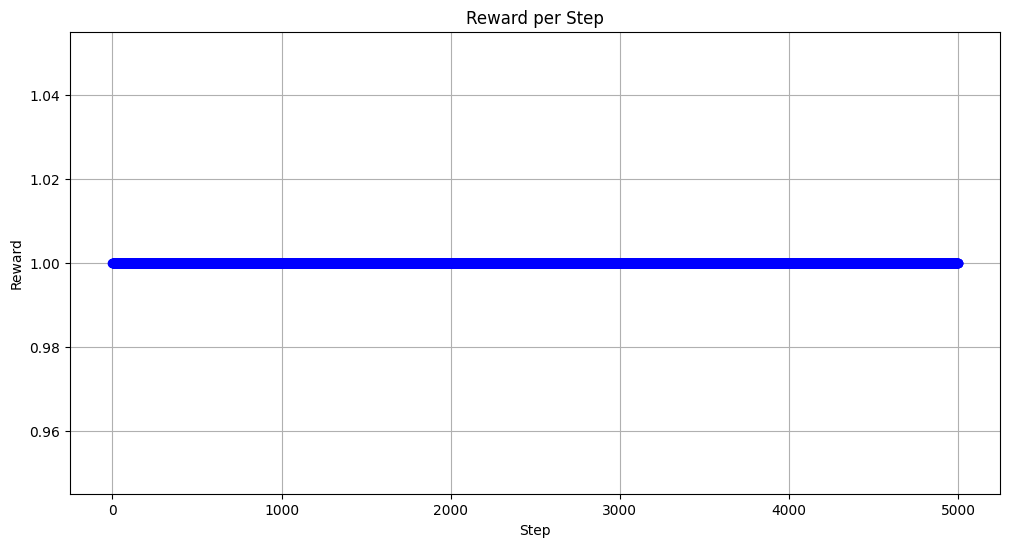

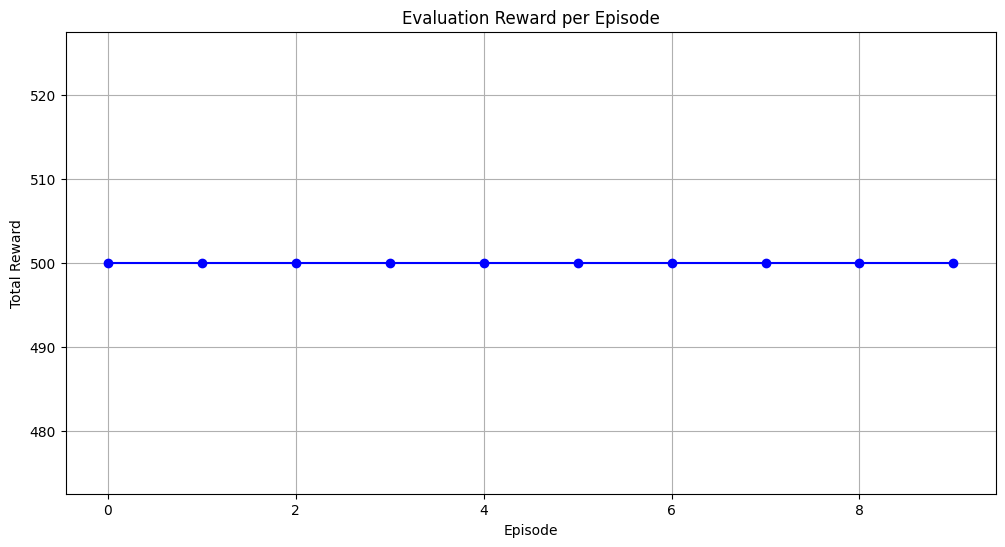

In [ ]:
# This code evaluates and visualizes a reinforcement learning model using a Gym environment.
#
# It consists of three main components:
# 1. **`value_function`**: Computes the value of a given state using a set of weights. It handles both single-dimensional and multi-dimensional states by flattening them if necessary.
# 2. **`evaluate_model`**: Runs an evaluation of the model within a Gym environment, capturing frames of the environment's render at each step. It calculates and prints performance metrics such as total reward, total steps taken, and average reward per step. The frames are resized for consistency before being stored.
# 3. **`plot_animation`**: Generates an animation from the captured frames and saves it as a GIF. The animation is then displayed using HTML for interactive playback.
#
# The cell demonstrates how to use these functions with the 'CartPole-v1' environment:
# - Initializes the environment with RGB array rendering mode.
# - Defines random weights for the model.
# - Evaluates the model and captures the frames of the environment.
# - Creates and saves an animation of the captured frames.
# - Displays the animation in a Jupyter notebook.
# - Plots the rewards per episode of the evaluation


def load_model(path, env):
    """Load a trained model."""
    return A2C.load(path, env=env)

# Define a function to get action from the model
def get_action_from_model(model, state):
    """Get the action from the trained model for a given state."""
    state = np.expand_dims(state, axis=0)  # Ensure state is batched
    action, _ = model.predict(state)  # Get the action from the model
    return action[0]

def evaluate_model(env, model, max_steps=2000):
    """Evaluate the model and capture frames of an episode using the trained model."""
    frames = []
    episode_rewards = []
    rewards_per_step = []
    total_reward = 0
    cumulative_reward = 0
    steps_taken = 0
    episode_count = 0

    state = env.reset()
    done = False

    while steps_taken < max_steps:
        img = env.render()  # Render the environment
        if img is not None:
            img = cv2.resize(np.squeeze(img), (300, 200))
            frames.append(img)  # Append the resized frame

        # Reshape state if necessary
        state = np.squeeze(state)
        if state.ndim == 1:
            state = np.expand_dims(state, axis=0)  # Add batch dimension if missing

        # Get action from the model
        action, _ = model.predict(state, deterministic=True)  # Get the action from the model

        # Take the action and get the result
        state, reward, done, info = env.step(action)  # New API returns 4 values

        rewards_per_step.append(reward)
        total_reward += reward
        cumulative_reward += reward
        steps_taken += 1

        if done:
            episode_rewards.append(total_reward)
            episode_count += 1
            # print(f"Episode finished with reward: {total_reward}")
            state = env.reset()  # Reset the environment for a new episode
            total_reward = 0

        if steps_taken >= max_steps:
            print("Reached maximum steps.")
            break

    env.close()

    # Ensure avg_reward_per_step is a scalar
    avg_reward_per_episode = np.mean(episode_rewards) if episode_rewards else 0
    avg_reward_per_step = cumulative_reward / steps_taken if steps_taken > 0 else 0

    # Convert to scalar if it's an ndarray
    avg_reward_per_step = avg_reward_per_step.item() if isinstance(avg_reward_per_step, np.ndarray) else avg_reward_per_step
    avg_reward_per_episode = avg_reward_per_episode.item() if isinstance(avg_reward_per_episode, np.ndarray) else avg_reward_per_episode

    # Print evaluation statistics
    print(f"Captured {len(frames)} frames.")
    print(f"Total Reward (across all episodes): {np.sum(episode_rewards)}")
    print(f"Total Steps Taken: {steps_taken}")
    print(f"Average Reward per Step: {avg_reward_per_step:.2f}")  # Should now be a scalar
    print(f"Average Reward per Episode: {avg_reward_per_episode:.2f}")  # Should now be a scalar
    print(f"Total Number of Episodes: {episode_count}")

    return frames, episode_rewards, rewards_per_step

# Define a function to plot animation
def plot_animation(frames):
    """Plot and return the animation object."""
    if not frames:
        print("No frames to plot.")
        return None

    fig, ax = plt.subplots(figsize=(6, 4))  # Adjust the figure size

    # Create a patch for the first frame
    patch = plt.imshow(frames[0], interpolation='none')
    plt.axis('off')

    def update_scene(num):
        patch.set_data(frames[num])
        return patch,

    # Create the animation
    anim = animation.FuncAnimation(fig, update_scene, frames=len(frames), interval=50, repeat=True)

    plt.close(fig)  # Close the figure to prevent display issues

    return anim

# Load the trained model
env = DummyVecEnv([lambda: gym.make("CartPole-v1", render_mode="rgb_array")])
model = load_model("trained_a2c_model", env)

# Evaluate the model and capture frames
frames, evaluation_rewards, rewards_per_step = evaluate_model(env, model, max_steps=5000)

# Plot the animation and get the animation object
anim = plot_animation(frames)

# Display the animation as HTML5 video with playback controls
if anim:
    display(HTML(anim.to_html5_video()))

# Plot the reward per step
plt.figure(figsize=(12, 6))
plt.plot(rewards_per_step, marker='o', linestyle='-', color='b')
plt.title("Reward per Step")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

# Plot the evaluation rewards per episode
plt.figure(figsize=(12, 6))
plt.plot(evaluation_rewards, marker='o', linestyle='-', color='b')
plt.title("Evaluation Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()
